<a href="https://colab.research.google.com/github/Evg20095/Customer_outflow/blob/master/Customer_outflow_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# считываем данные
train_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/uma/TRAIN_PREPARED.csv', index_col='email')
test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/uma/TEST_PREPARED.csv', index_col='email')

In [0]:
# изменим формат некоторых данных
times = ['cut_date', 'first_date', 'last_date']
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [0]:
# выделим целевую переменную
df_y_train = train_df['label']

# удалим слобец label
train_df.drop(['label'], axis='columns', inplace=True)

In [0]:
# избавимся от столбцов с датой
# train_df.drop(times, axis='columns', inplace=True)

In [0]:
# преобразуем формат даты в таблице
train_df['cut_date'] = train_df['cut_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)
train_df['first_date'] = train_df['first_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)
train_df['last_date'] = train_df['last_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)
test_df['cut_date'] = test_df['cut_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)
test_df['first_date'] = test_df['first_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)
test_df['last_date'] = test_df['last_date'].apply(lambda ts: 10000*ts.year + 100*ts.month + ts.day)

In [0]:
# нормализуем данные
columns = train_df.loc[:,'cut_date':'pc_max_30days'].columns
def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        np.seterr(divide='ignore', invalid='ignore')
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
train_df_new = normalize(train_df, columns)
test_df_new = normalize(test_df, columns)
# заменим пропуски на 0
test_df_new = test_df_new.fillna(0)

In [0]:
train_df_new.head()

In [0]:
# Попробуем подобрать хорошие гипер параметры.
# Здесь можно попробовать вручную подобрать коэф. регуляризации. Я остановился на единице.
#
def get_auc_lr_valid(X, y, C=1, ratio = 0.9, seed=17):
    '''
    X, y – данные, метки
    ratio – соотношениее частей выборки
    C, seed – коэф-т регуляризации и random_state 
    
    '''
    train_len = int(ratio * X.shape[0])
    X_train = X[:train_len]
    X_valid = X[train_len:]
    y_train = y[:train_len]
    y_valid = y[train_len:]

    logit = LogisticRegression(C=C, class_weight='balanced', n_jobs=-1, random_state=seed)

    logit.fit(X_train, y_train)
    valid_pred = logit.predict_proba(X_valid)[:, 1]
    print(valid_pred)
    return roc_auc_score(y_valid, valid_pred)

In [0]:
%%time
get_auc_lr_valid(train_df_new, df_y_train)

Как можно видеть, качество предсказания оставляет желать лучшего. Я немного поэкспериментировал с гиперпараметрами, но результат не изменился. Врятли на тестовой выборке качество предсказания резко улучшится. Что же делать?

Есть два пути: 
1. Можно попробовать другие алгоритмы, случайный лес или даже нейронные сети. Я думаю что не стоит везде пытаться притянуть нейронку, хотя для задач оттока есть любопытные статьи на эту тему. Но в экспериментальных целях можно попробовать. Попробуем градиентный бустинг.
2. Можно попробовать поработать с данными. Но это может занять много времени и я не нашёл описания фичей. И ещё, очень важно, зависимость целевой переменной от фичей может быть такой, что логистическая регрессия просто не сможет эффективно разделить гиперплоскостью пространство признаков на два полупространства. Попробуем бустинг.

Градиентный бустинг

In [0]:
# обработка данных
X, y = train_df_new, df_y_train

ratio = 0.9

train_len = int(ratio * X.shape[0])
X_train = X[:train_len]
X_valid = X[train_len:]
y_train = y[:train_len]
y_valid = y[train_len:]

In [0]:
# Опишем модель
xgb_model = xgb.XGBClassifier(max_depth=7, learning_rate=0.7, verbosity=1, n_jobs=-1, n_estimators=250)
xgb_model.fit(X_train, y_train, eval_metric="merror")

In [0]:
predict_labels = xgb_model.predict(X_valid)

# В задаче оттока важно найти всех клиентов, которые могут уйти. Если мы ошибёмся в том, что назовём лояльного клиента уходящим и ему позвонит менеджер, которому это делать было не обязательно, это будет не так страшно, как если мы пропустим, уходящего клиента. Поэтому я выбрал метрику recall для оценки модели.

In [57]:
# полнота
round(recall_score(y_valid, predict_labels), 3)

0.915

In [48]:
# метрика качества классификации
round(f1_score(y_valid, predict_labels), 3)

0.939

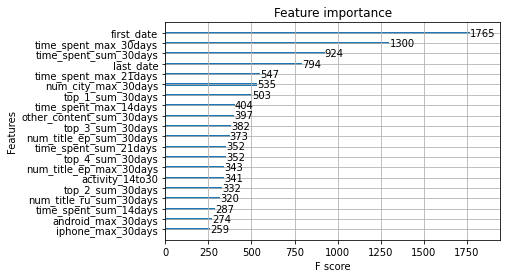

In [53]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [0]:
# получим вероятности для тестовой выборки
predict_labels_test_proba = xgb_model.predict_proba(test_df_new)[:, 1]

# округлим вероятности
predict_labels_test_proba = [ '%.3f' % elem for elem in predict_labels_test_proba ]

In [0]:
# создадим scv файл
pd.Series(predict_labels_test_proba, index=test_df_new.index, name='prediction').to_csv('Customer_outflow_prediction.csv', header=True)

In [0]:
!head Customer_outflow_prediction.csv

Здесь явно нехватает алгоритма выбора гиперпараметров. И графика с метриками  от гиперпараметров. И сравнения градиентного бустинга с нейроной сетью, логистическая регрессия, это явно не та "весовая категория".

Я знаю, что ложка хороша к обеду, но так сложились обстоятельства, что у меня было только субота и восресенье на решение задачи. Если есть возможность решить другой тест, я бы ей с удовольствием воспользовался и использовал всё свободное время.